# Andiamo a caricare il file con la resa

In [114]:
import rasterio
from matplotlib import pyplot as plt
import pickle
import numpy as np
from tsmoothie.smoother import LowessSmoother
from mpl_toolkits.mplot3d import axes3d
from datetime import datetime
import skfda
from skfda.representation.interpolation import SplineInterpolation
from sklearn.preprocessing import normalize

(56, 72)
[[    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.   7282.1  6796.   6806.5  8419.6  7417.9  7409.8  7554.9
   5271.1  6534.1  7941.2  7744.3  7762.2  7638.9  5898.   6455.4  7102.3
   7504.7  7910.1  7522.8  5949.3    99.9  3089.9  4058.4     0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
   6142.5  6650.7  6426.   9171.4  876

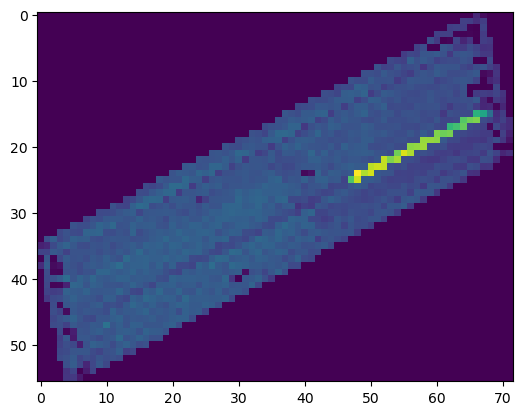

In [115]:
resa3 = rasterio.open(r'OUTPUT.tif')
print(resa3.shape)
plt.imshow(resa3.read(1))
resa3 = resa3.read(1)
print(resa3[10:20])

In [116]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)

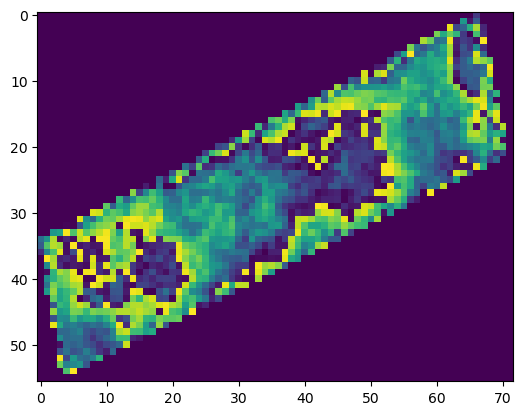

In [117]:
campo3 = rasterio.open(r'campo3.tiff')
plt.imshow(campo3.read(1))

# Procediamo ad aggiungere i valori della resa all'immagine

(57, 12, 56, 72)


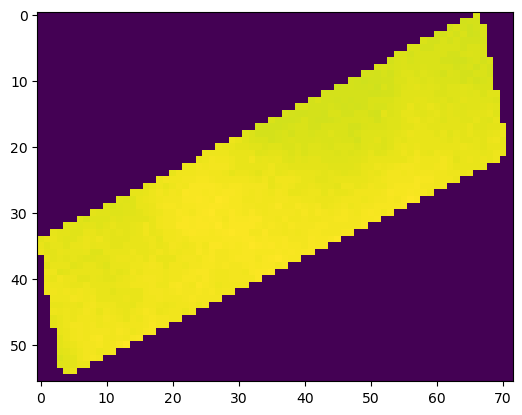

In [118]:
with open('campo3_bande.pickle', 'rb') as handle:
    campo3 = pickle.load(handle)
print(campo3.shape)
plt.imshow(campo3[4][2])

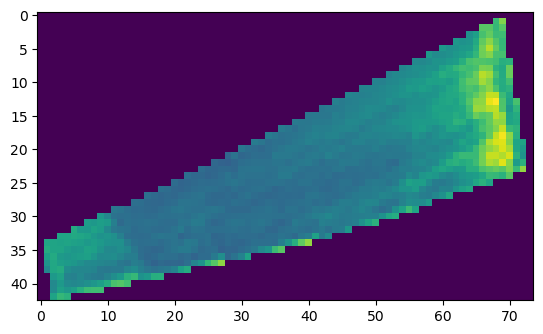

In [119]:
with open('campo4_bande.pickle', 'rb') as handle:
    campo4 = pickle.load(handle)
plt.imshow(campo4[30][2])

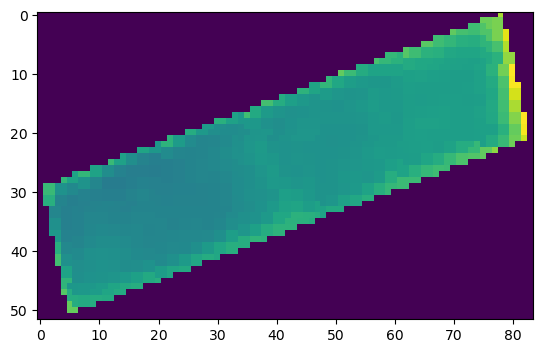

In [120]:
with open('campo6_bande.pickle', 'rb') as handle:
    campo6 = pickle.load(handle)
plt.imshow(campo6[40][10])

(1579,)


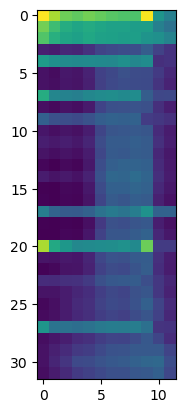

In [121]:
newImage3 = []
newResa3 = []
for x in range(0, campo3.shape[2]):
    for y in range(0,campo3.shape[3]):
        if(np.sum(campo3[:,:,x,y] != 0)):
            newImage3.append(campo3[18:50,:,x,y]/12000) # Abbiamo preso l'intervallo consigliato dal professore
            newResa3.append(resa3[x,y])
newResa3 = np.array(newResa3)
print(newResa3.shape)
plt.imshow(newImage3[10])

# Mi salvo l'ordine delle rese che ssegue l'ordine dei pixel

with open('newResa3.pickle', 'wb') as handle:
    pickle.dump(newResa3, handle, protocol=pickle.HIGHEST_PROTOCOL)

(1579, 32, 12)


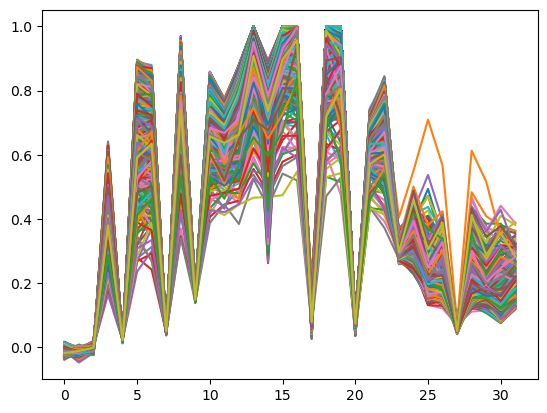

In [95]:
print(np.array(newImage3).shape)
for a in range(0,np.array(newImage3).shape[0]):
    plt.plot((newImage3[a][:,7]-newImage3[a][:,3])/(newImage3[a][:,7]+newImage3[a][:,3]))

# Andiamo a eseguire un' operazione di smoothing

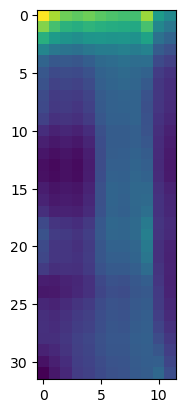

In [150]:
imageSmooth = newImage3

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.01, iterations=1)

for x in range(len(newImage3)):
    for banda in range(0,campo3.shape[1]):
        imageSmooth[x][:,banda] = smoother.smooth(newImage3[x][:,banda]).smooth_data[0]

plt.imshow(imageSmooth[10])


(1579, 32, 12)


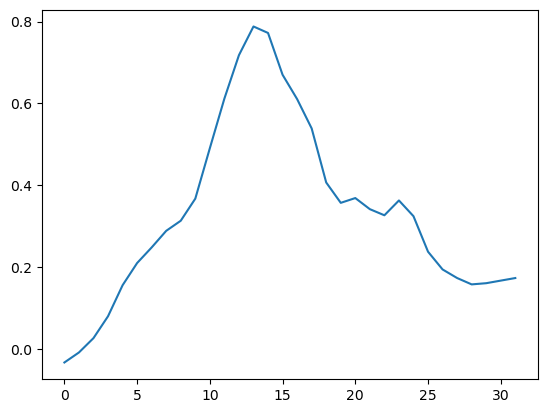

In [123]:
print(np.array(imageSmooth).shape)
for a in range(0,np.array(imageSmooth).shape[0]):
    plt.plot((imageSmooth[a][:,7]-imageSmooth[a][:,3])/(imageSmooth[a][:,7]+imageSmooth[a][:,3]))

# Interpolazione

In [124]:
date = ['2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
days = []
zeroDay = datetime.strptime("2017-01-01","%Y-%m-%d")
date_cut = date[18:50]
for a in date_cut:
    days.append((datetime.strptime(a,"%Y-%m-%d")-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves

inter = skfda.FDataGrid(
    data_matrix=np.transpose(imageSmooth), #imageSmooth[0]
    grid_points=grid_points,
)
 
#inter.plot()

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]


In [125]:
inter.interpolation = SplineInterpolation(
    interpolation_order= 3
)
#inter.plot()

In [126]:
step = 5
test = inter.interpolation._evaluate(inter,range(43,193,step))
#newInter = inter.interpolation._evaluate(inter,range(43,193,5))[:,:,0]
print(test[:,:,:].shape)


(12, 30, 1579)


# Array di pixel ( altro metodo )

In [140]:
allPixel = []
inter = []
for a in range(0,np.array(imageSmooth).shape[0]):
    #inter.data_matrix = np.transpose(imageSmooth[a])
    #inter.interpolation = SplineInterpolation(interpolation_order= 3)
    inter.append(skfda.FDataGrid(
        data_matrix = np.transpose(imageSmooth[a]),
        grid_points=grid_points,
        interpolation= SplineInterpolation(interpolation_order= 3)
    ))
    allPixel.append(inter[-1].interpolation._evaluate(inter[-1],range(43,193))[:,:,0])

inter = np.array(inter)

11064.0
4026.3
1507 3
plot
Data set:    [[[1.28465548]
  [1.04010787]
  [0.80642571]
  [0.57593806]
  [0.39860355]
  [0.33879563]
  [0.31934657]
  [0.2905927 ]
  [0.28017262]
  [0.24289818]
  [0.1620791 ]
  [0.10597383]
  [0.06502085]
  [0.03918453]
  [0.04912212]
  [0.10001508]
  [0.13000441]
  [0.16990371]
  [0.2645058 ]
  [0.2951168 ]
  [0.25678775]
  [0.24607295]
  [0.20496724]
  [0.11066661]
  [0.09962184]
  [0.16793409]
  [0.19957741]
  [0.20355352]
  [0.20093928]
  [0.14330376]
  [0.07459417]
  [0.0030802 ]]

 [[1.14219426]
  [0.92927984]
  [0.72513784]
  [0.52370192]
  [0.36057862]
  [0.29226788]
  [0.26242416]
  [0.22805086]
  [0.21515133]
  [0.1872272 ]
  [0.12659563]
  [0.08418867]
  [0.05279705]
  [0.03263652]
  [0.04196506]
  [0.08652059]
  [0.11263178]
  [0.13887416]
  [0.20044597]
  [0.21553654]
  [0.18218858]
  [0.17711063]
  [0.15685757]
  [0.10151631]
  [0.10111543]
  [0.15108916]
  [0.17626761]
  [0.18496686]
  [0.1884309 ]
  [0.15335389]
  [0.1110532 ]
  [0.06674171

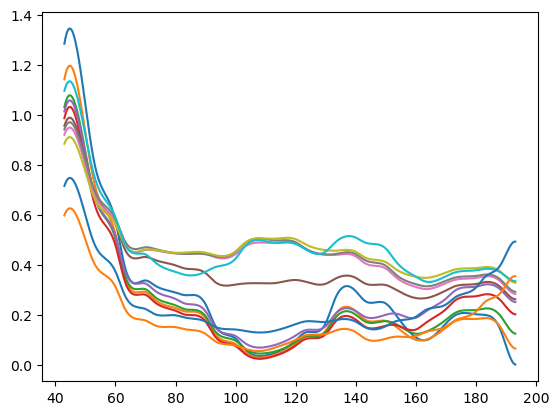

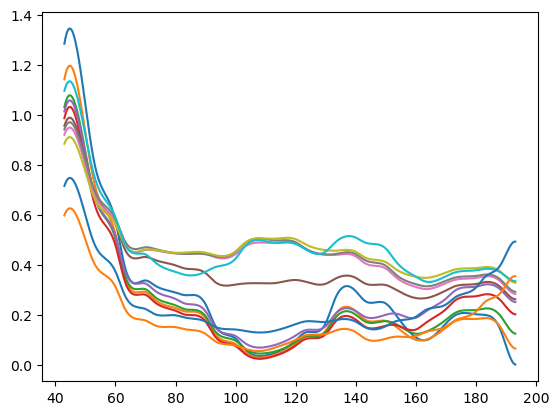

In [128]:
#print(len(inter))
#print(len(newResa3))
#print(max(newResa3))
inter = []
for a in range(0,np.array(imageSmooth).shape[0]):
    #inter.data_matrix = np.transpose(imageSmooth[a])
    #inter.interpolation = SplineInterpolation(interpolation_order= 3)
    inter.append(skfda.FDataGrid(
        data_matrix = np.transpose(imageSmooth[a]),
        grid_points = grid_points,
        interpolation = SplineInterpolation(interpolation_order= 3)
    ))


Medium = 4000
HighValue = 12000
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
ResaFilter = newResa3[Resa3MediumFilter]
#interFiltered = inter[Resa3MediumFilter]

maxResa = np.where(newResa3 == ResaFilter.max())[0][0]
minResa = np.where(newResa3 == ResaFilter.min())[0][0]

#print(newImage3[maxResa]-newResa3[minResa])
print(newResa3[maxResa])
print(newResa3[minResa])
print(str(maxResa)+" "+str(minResa))
print("plot")
print(inter[maxResa])
inter[maxResa].plot()




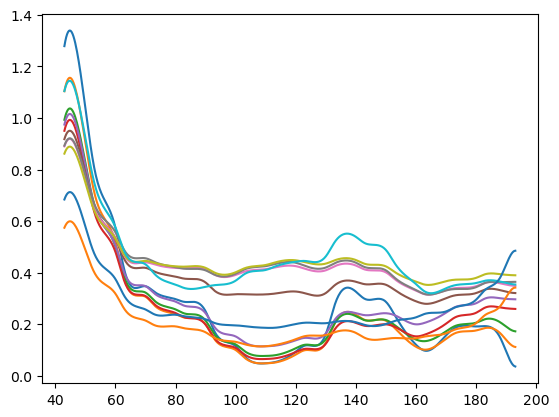

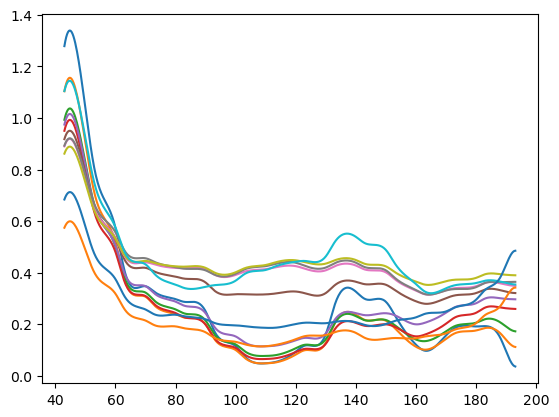

In [129]:
inter[minResa].plot()

In [ ]:
allPixelRw = []
interRw = []
for a in range(0,np.array(newImage3).shape[0]):
    #inter.data_matrix = np.transpose(newImage3[x][a])
    #inter.interpolation = SplineInterpolation(interpolation_order= 3)
    interRw.append(skfda.FDataGrid(
        data_matrix = np.transpose(newImage3[a]),
        grid_points=grid_points,
        interpolation= SplineInterpolation(interpolation_order= 1)
    ))
    allPixelRw.append(interRw[-1].interpolation._evaluate(interRw[-1],range(43,193))[:,:,0])

[[1.25989224 1.30757252 1.31805195 ... 0.082893   0.05387189 0.03191318]
 [1.10792669 1.14979249 1.15933545 ... 0.13000557 0.11743678 0.1079281 ]
 [0.99631749 1.03134961 1.03935548 ... 0.18190186 0.17309784 0.16643294]
 ...
 [1.06553784 1.09756282 1.10366922 ... 0.41019035 0.40756239 0.40562165]
 [0.6827614  0.704162   0.70930295 ... 0.38065893 0.39871094 0.41235659]
 [0.57185155 0.58954992 0.59407578 ... 0.27226751 0.28327171 0.2915546 ]]
(1579, 12, 150)
(1579, 150)


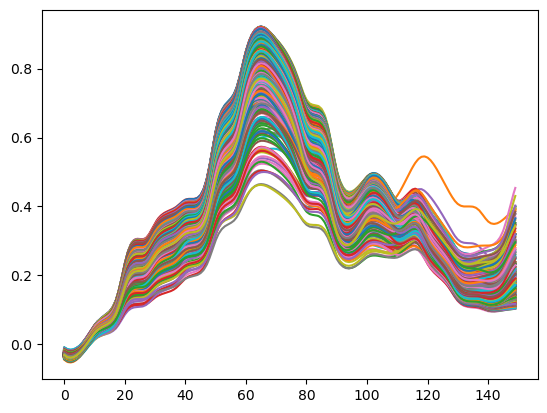

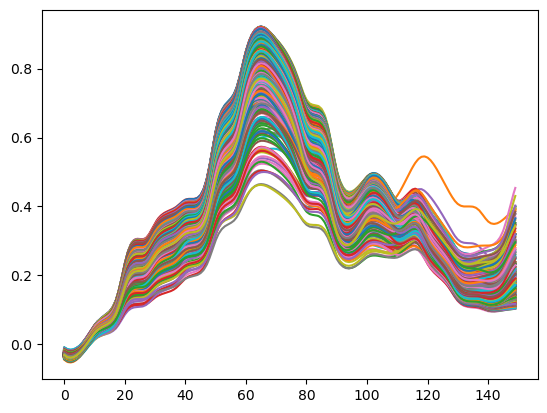

In [144]:
print(allPixel[0])
pixels = np.array(allPixel)
print(pixels.shape)
NDVI = (pixels[:,7,:] - pixels[:,3,:])/(pixels[:,7,:] + pixels[:,3,:])
print(NDVI.shape)



#plt.plot((imageSmooth[10][:,7]-imageSmooth[10][:,3])/(imageSmooth[10][:,7]+imageSmooth[10][:,3]))
skfda.FDataGrid(
        data_matrix = NDVI,
        grid_points=range(43,193)
    ).plot()



#range(43,193)


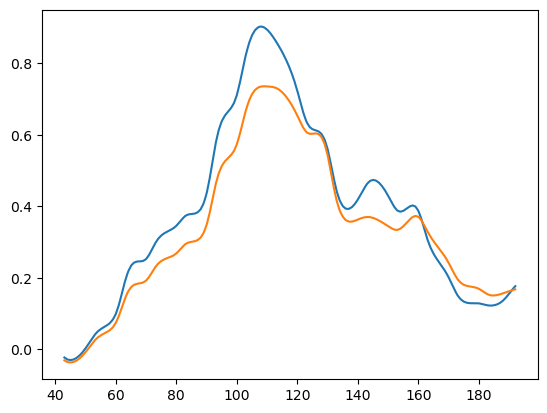

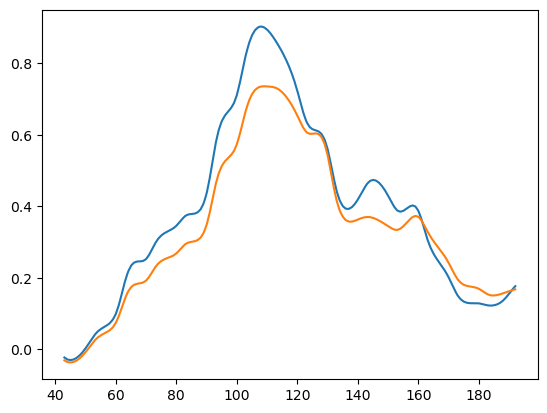

In [148]:

skfda.FDataGrid(
        data_matrix = NDVI[(maxResa,minResa),:],
        grid_points=range(43,193)
    ).plot()

[[1.25989224 1.18819992 0.80563329 0.65511086 0.42799231 0.3637178
  0.34288668 0.32154737 0.30416953 0.29583726 0.1926041  0.15269555
  0.11366959 0.09350025 0.10024532 0.12037001 0.15017538 0.15379954
  0.30204397 0.36360186 0.32632522 0.32538214 0.24923854 0.15915382
  0.10698893 0.14028897 0.19202121 0.19727528 0.19057433 0.14155074]
 [1.10792669 1.04792908 0.71887882 0.59157522 0.38937699 0.32431167
  0.28806146 0.26262461 0.24282481 0.23597343 0.15883315 0.12740948
  0.09140681 0.07205911 0.07527367 0.09359346 0.12153417 0.12472663
  0.22357945 0.26333092 0.2316567  0.23218224 0.19217172 0.13541778
  0.10434802 0.12724591 0.16084983 0.16529446 0.17576424 0.15582302]
 [0.99631749 0.94624255 0.67078081 0.5637813  0.39653794 0.34322158
  0.30936871 0.28545527 0.26257589 0.25363873 0.18451012 0.15726781
  0.13008985 0.11559021 0.1198422  0.13536728 0.15585982 0.15691049
  0.23486652 0.266521   0.2406038  0.24110887 0.21008164 0.16462303
  0.14177291 0.1623047  0.19388766 0.19929438 0

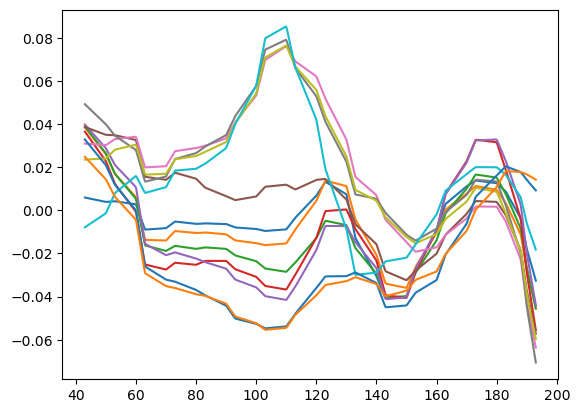

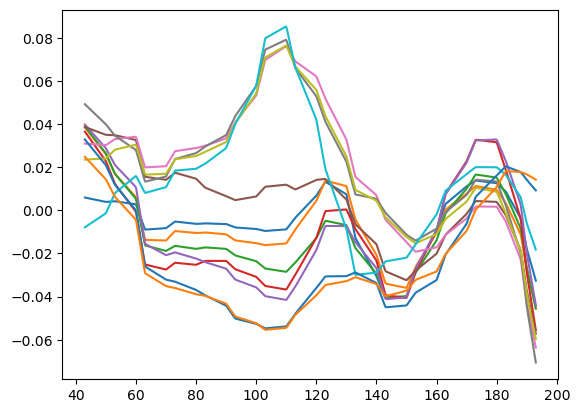

In [133]:


skfda.FDataGrid(
        data_matrix = np.transpose(imageSmooth[maxResa] - imageSmooth[minResa]),
        grid_points=grid_points
    ).plot()

(1579, 12, 30)


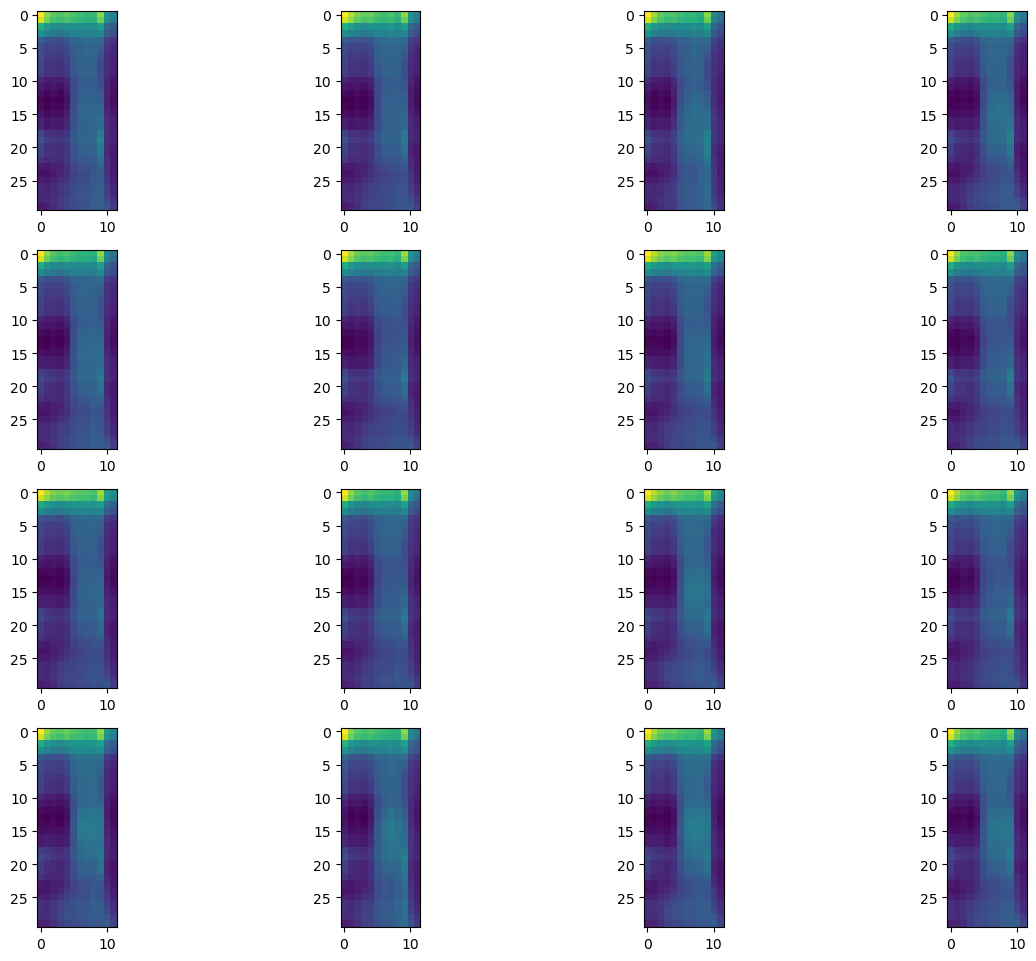

In [56]:
allPixel = np.array(allPixel)
print(allPixel.shape)

#fig = plt.figure(figsize=(10,9))
#f, axarr = plt.subplots(15,1) 
'''plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

for a in range(0,4):
    plt.subplot(1, 4, a+1)
    plt.imshow(np.transpose(allPixel[(a*150),:,:]))
    #axarr[a].imshow()
plt.show()'''



fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(allPixel[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [57]:
print(allPixel[10:20,7,15])

with open('AllPixelBand3.pickle', 'wb') as handle:
    pickle.dump(allPixel, handle, protocol=pickle.HIGHEST_PROTOCOL)

[0.41178119 0.43490769 0.4491163  0.4482844  0.43224926 0.42841793
 0.42699436 0.41510026 0.41795732 0.41156261]


# Test per aumentare le piccole differenze 

In [38]:
Prüfung = allPixel
Prüfung = (Prüfung*100)-100
Prüfung = (Prüfung- np.min(Prüfung))/np.ptp(Prüfung)

(1579, 12, 30)


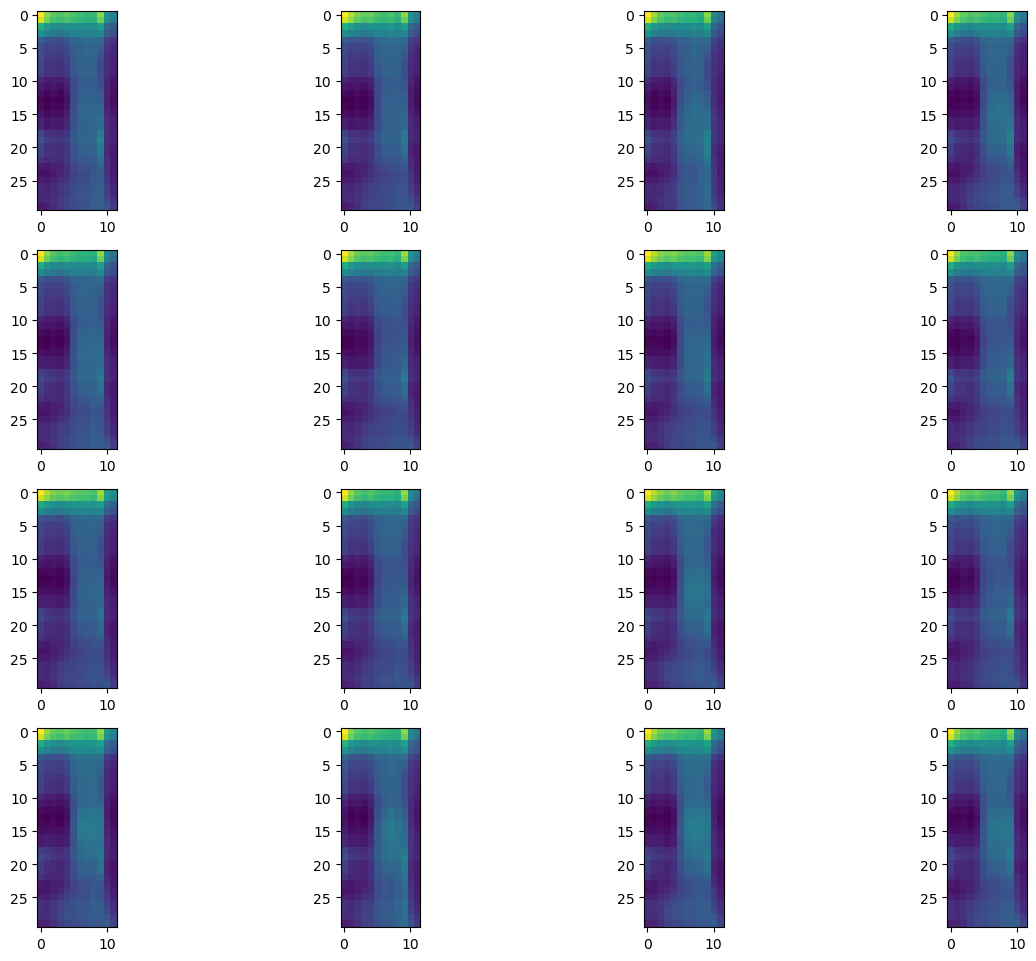

In [39]:
print(Prüfung.shape)
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,17):
    img = np.transpose(Prüfung[(i*70),:,:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [40]:
print(Prüfung[10:20,7,15])

[0.28994112 0.30712797 0.31768735 0.31706911 0.30515232 0.30230499
 0.30124705 0.29240774 0.29453101 0.28977867]
